In [188]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using Juno

---

In [ ]:
function supertypes(T)
    current = T
    println(current)
    while current != Any
        current = supertype(current)
        println(current)
    end
end

In [138]:
function scale_center(x; dims = 1)
    x = x .- mean(x, dims = dims)
    norm = sqrt.(sum(x .^ 2, dims = dims))
    x ./ norm
end

scale_center (generic function with 1 method)

---

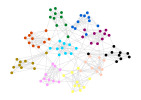

In [279]:
l = 10
k = 10
g = LightGraphs.SimpleGraphs.stochastic_block_model(0.8 * k, .2, k .* ones(UInt, l), seed = 1)
communities = [c for c in 1:l for i in 1:k]
features = scale_center(Flux.onehotbatch(communities, 1:l))

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [280]:
palette

In [281]:
A = Array(adjacency_matrix(g))

100×100 Array{Int64,2}:
 0  1  1  1  0  1  1  1  0  1  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  1  1  1  1  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  1  1  0  1  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 1  1  1  0  1  1  1  1  1  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  0  1  1  1  1  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  1  1  0  1  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  1  1  1  0  1  1  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  0  1  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  0  1  1  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  1  1  1  1  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  1  0  

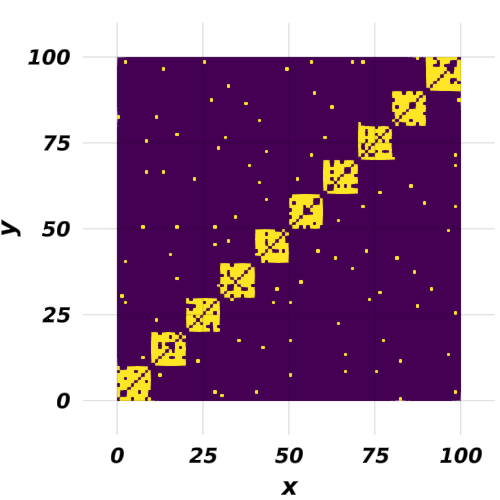

In [282]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, A)

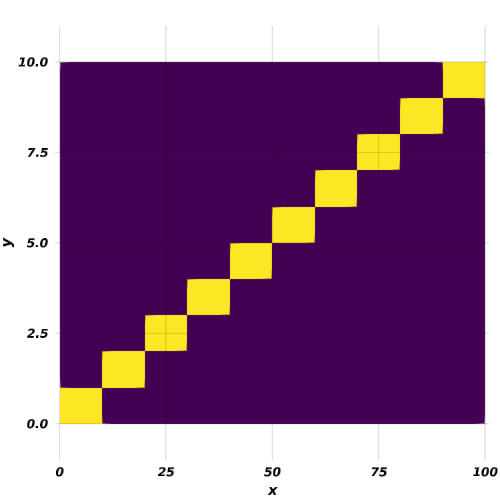

In [283]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, features)

---

In [284]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Statistics

In [285]:
module layers


using Flux
using LinearAlgebra

struct GC{V,F}
    Â::AbstractArray{V}
    W::AbstractArray{V}
    b::AbstractArray{V}
    σ::F
    function GC(A::AbstractArray{V}, W::AbstractArray{V}, b::AbstractArray{V}, σ::F) where {V,F}
        Ã = A + Matrix(I, size(A)...)
        Ãsumout_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 1), dims = 1))
        Ãsumin_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 2), dims = 2))
        # TODO: Figure this out for the non-symmetrical A case,
        # being careful that layer calling is transposed compared to python
        Â = diagm(0 => Ãsumout_inv_sqrt) * Ã * diagm(0 => Ãsumin_inv_sqrt)
        new{V,F}(Â, W, b, σ)
    end
end

GC(A, W, b) = GC(A, W, b, identity)

function GC(A::AbstractArray, in::Integer, out::Integer, σ = identity;
            initW = Flux.glorot_uniform, initb = zeros)
    return GC(convert(AbstractArray{Float64}, A), param(initW(out, in)), param(initb(out)), σ)
end

Flux.@treelike GC

(a::GC)(x::AbstractArray) = a.σ.((a.W * x * a.Â) .+ a.b)

function Base.show(io::IO, l::GC)
    print(io, "GC(A ~ ", size(l.Â), ", W ~ ", (size(l.W, 2), size(l.W, 1)))
    l.σ == identity || print(io, ", ", l.σ)
    print(io, ")")
end


struct Bilin{F}
    σ::F
end

Bilin() = Bilin(identity)

(a::Bilin)(x::AbstractArray) = a.σ.(transpose(x) * x)


end

Main.layers

In [298]:
diml1 = Int64(l / 2)
enc = Chain(layers.GC(A, l, diml1, Flux.relu), layers.GC(A, diml1, 2))
dec = Chain(Dense(2, diml1, Flux.relu), layers.Bilin())
ae = Chain(enc, dec)

Chain(Chain(GC(A ~ (100, 100), W ~ (10, 5), NNlib.relu), GC(A ~ (100, 100), W ~ (5, 2))), Chain(Dense(2, 5, NNlib.relu), Main.layers.Bilin{typeof(identity)}(identity)))

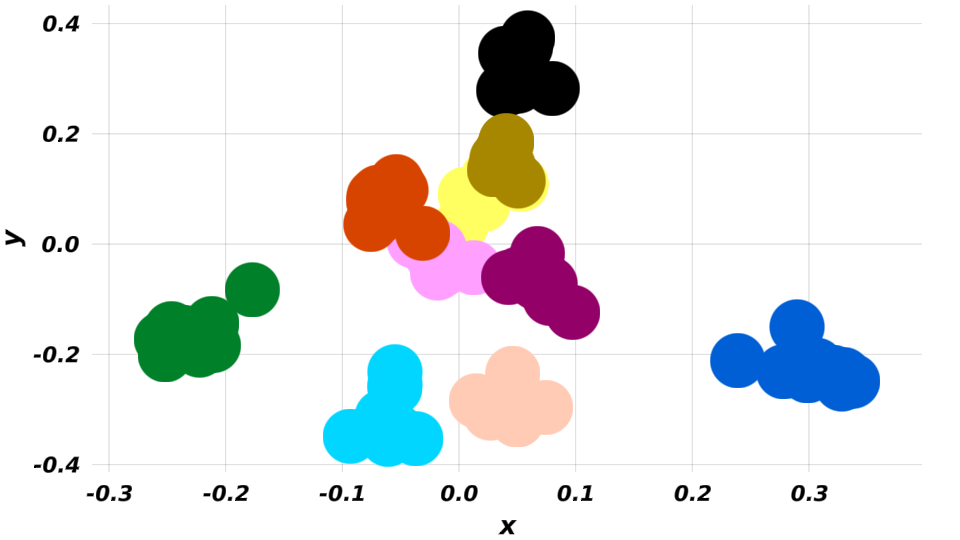

In [299]:
emb = enc(features)
scene = Scene(resolution = (500, 500))
scatter(emb[1, :], emb[2, :], color = colors)

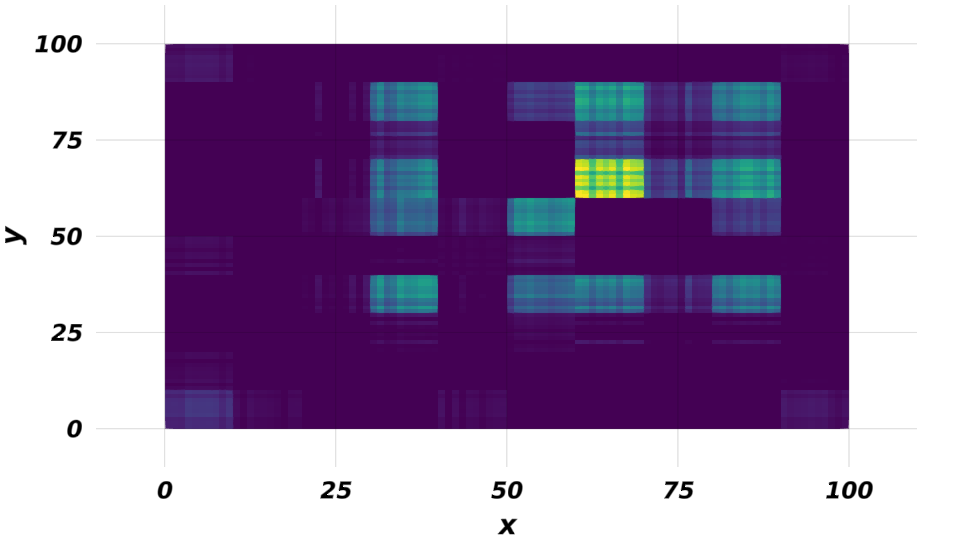

In [300]:
scene = Scene(resolution = (500, 500))
heatmap(ae(features).data)

In [301]:
function colorbar(x)
    a = range(minimum(x), stop = maximum(x), length = 100) |> collect
    heatmap(reshape(a, 1, :))
end

colorbar (generic function with 1 method)

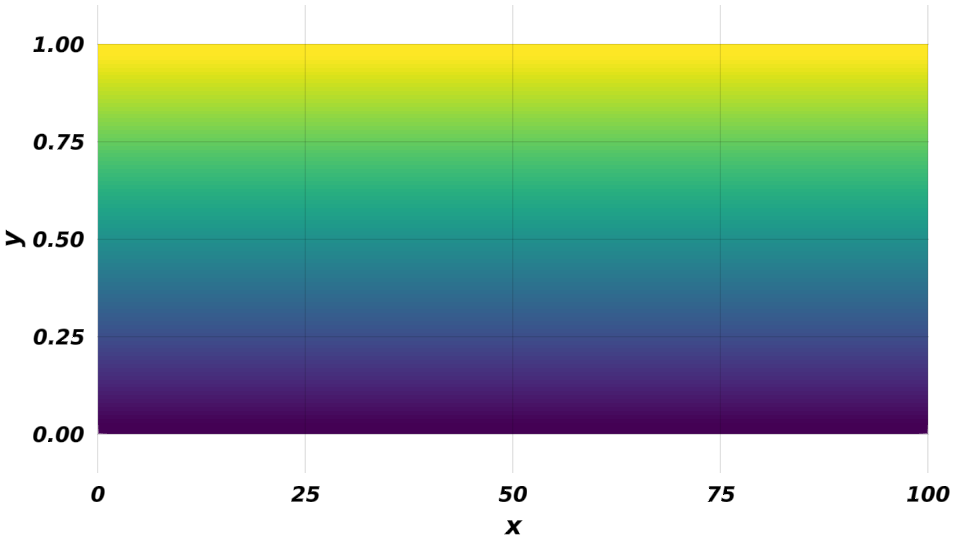

In [302]:
colorbar(A)

In [305]:
loss(X) = l * k * mean(Flux.logitbinarycrossentropy.(ae(X), A)) + 0.01 * sum(x -> sum(x.^2), params(enc))
evalcb = Flux.throttle(() -> @show(loss(features)), 30)
opt = ADAM(params(ae))
Juno.@progress for i = 1:2000
  @info "Epoch $i"
  Flux.train!(loss, zip([features]), opt, cb=evalcb)
end

┌ Info: Epoch 1
└ @ Main In[305]:5


loss(features) = 68.86468671925869 (tracked)


┌ Info: Epoch 2
└ @ Main In[305]:5
┌ Info: Epoch 3
└ @ Main In[305]:5
┌ Info: Epoch 4
└ @ Main In[305]:5
┌ Info: Epoch 5
└ @ Main In[305]:5
┌ Info: Epoch 6
└ @ Main In[305]:5
┌ Info: Epoch 7
└ @ Main In[305]:5
┌ Info: Epoch 8
└ @ Main In[305]:5
┌ Info: Epoch 9
└ @ Main In[305]:5
┌ Info: Epoch 10
└ @ Main In[305]:5
┌ Info: Epoch 11
└ @ Main In[305]:5
┌ Info: Epoch 12
└ @ Main In[305]:5
┌ Info: Epoch 13
└ @ Main In[305]:5
┌ Info: Epoch 14
└ @ Main In[305]:5
┌ Info: Epoch 15
└ @ Main In[305]:5
┌ Info: Epoch 16
└ @ Main In[305]:5
┌ Info: Epoch 17
└ @ Main In[305]:5
┌ Info: Epoch 18
└ @ Main In[305]:5
┌ Info: Epoch 19
└ @ Main In[305]:5
┌ Info: Epoch 20
└ @ Main In[305]:5
┌ Info: Epoch 21
└ @ Main In[305]:5
┌ Info: Epoch 22
└ @ Main In[305]:5
┌ Info: Epoch 23
└ @ Main In[305]:5
┌ Info: Epoch 24
└ @ Main In[305]:5
┌ Info: Epoch 25
└ @ Main In[305]:5
┌ Info: Epoch 26
└ @ Main In[305]:5
┌ Info: Epoch 27
└ @ Main In[305]:5
┌ Info: Epoch 28
└ @ Main In[305]:5
┌ Info: Epoch 29
└ @ Main In[305]:5


┌ Info: Epoch 235
└ @ Main In[305]:5
┌ Info: Epoch 236
└ @ Main In[305]:5
┌ Info: Epoch 237
└ @ Main In[305]:5
┌ Info: Epoch 238
└ @ Main In[305]:5
┌ Info: Epoch 239
└ @ Main In[305]:5
┌ Info: Epoch 240
└ @ Main In[305]:5
┌ Info: Epoch 241
└ @ Main In[305]:5
┌ Info: Epoch 242
└ @ Main In[305]:5
┌ Info: Epoch 243
└ @ Main In[305]:5
┌ Info: Epoch 244
└ @ Main In[305]:5
┌ Info: Epoch 245
└ @ Main In[305]:5
┌ Info: Epoch 246
└ @ Main In[305]:5
┌ Info: Epoch 247
└ @ Main In[305]:5
┌ Info: Epoch 248
└ @ Main In[305]:5
┌ Info: Epoch 249
└ @ Main In[305]:5
┌ Info: Epoch 250
└ @ Main In[305]:5
┌ Info: Epoch 251
└ @ Main In[305]:5
┌ Info: Epoch 252
└ @ Main In[305]:5
┌ Info: Epoch 253
└ @ Main In[305]:5
┌ Info: Epoch 254
└ @ Main In[305]:5
┌ Info: Epoch 255
└ @ Main In[305]:5
┌ Info: Epoch 256
└ @ Main In[305]:5
┌ Info: Epoch 257
└ @ Main In[305]:5
┌ Info: Epoch 258
└ @ Main In[305]:5
┌ Info: Epoch 259
└ @ Main In[305]:5
┌ Info: Epoch 260
└ @ Main In[305]:5
┌ Info: Epoch 261
└ @ Main In[305]:5
┌

┌ Info: Epoch 472
└ @ Main In[305]:5
┌ Info: Epoch 473
└ @ Main In[305]:5
┌ Info: Epoch 474
└ @ Main In[305]:5
┌ Info: Epoch 475
└ @ Main In[305]:5
┌ Info: Epoch 476
└ @ Main In[305]:5
┌ Info: Epoch 477
└ @ Main In[305]:5
┌ Info: Epoch 478
└ @ Main In[305]:5
┌ Info: Epoch 479
└ @ Main In[305]:5
┌ Info: Epoch 480
└ @ Main In[305]:5
┌ Info: Epoch 481
└ @ Main In[305]:5
┌ Info: Epoch 482
└ @ Main In[305]:5
┌ Info: Epoch 483
└ @ Main In[305]:5
┌ Info: Epoch 484
└ @ Main In[305]:5
┌ Info: Epoch 485
└ @ Main In[305]:5
┌ Info: Epoch 486
└ @ Main In[305]:5
┌ Info: Epoch 487
└ @ Main In[305]:5
┌ Info: Epoch 488
└ @ Main In[305]:5
┌ Info: Epoch 489
└ @ Main In[305]:5
┌ Info: Epoch 490
└ @ Main In[305]:5
┌ Info: Epoch 491
└ @ Main In[305]:5
┌ Info: Epoch 492
└ @ Main In[305]:5
┌ Info: Epoch 493
└ @ Main In[305]:5
┌ Info: Epoch 494
└ @ Main In[305]:5
┌ Info: Epoch 495
└ @ Main In[305]:5
┌ Info: Epoch 496
└ @ Main In[305]:5
┌ Info: Epoch 497
└ @ Main In[305]:5
┌ Info: Epoch 498
└ @ Main In[305]:5
┌

┌ Info: Epoch 716
└ @ Main In[305]:5
┌ Info: Epoch 717
└ @ Main In[305]:5
┌ Info: Epoch 718
└ @ Main In[305]:5
┌ Info: Epoch 719
└ @ Main In[305]:5
┌ Info: Epoch 720
└ @ Main In[305]:5
┌ Info: Epoch 721
└ @ Main In[305]:5
┌ Info: Epoch 722
└ @ Main In[305]:5
┌ Info: Epoch 723
└ @ Main In[305]:5
┌ Info: Epoch 724
└ @ Main In[305]:5
┌ Info: Epoch 725
└ @ Main In[305]:5
┌ Info: Epoch 726
└ @ Main In[305]:5
┌ Info: Epoch 727
└ @ Main In[305]:5
┌ Info: Epoch 728
└ @ Main In[305]:5
┌ Info: Epoch 729
└ @ Main In[305]:5
┌ Info: Epoch 730
└ @ Main In[305]:5
┌ Info: Epoch 731
└ @ Main In[305]:5
┌ Info: Epoch 732
└ @ Main In[305]:5
┌ Info: Epoch 733
└ @ Main In[305]:5
┌ Info: Epoch 734
└ @ Main In[305]:5
┌ Info: Epoch 735
└ @ Main In[305]:5
┌ Info: Epoch 736
└ @ Main In[305]:5
┌ Info: Epoch 737
└ @ Main In[305]:5
┌ Info: Epoch 738
└ @ Main In[305]:5
┌ Info: Epoch 739
└ @ Main In[305]:5
┌ Info: Epoch 740
└ @ Main In[305]:5
┌ Info: Epoch 741
└ @ Main In[305]:5
┌ Info: Epoch 742
└ @ Main In[305]:5
┌

┌ Info: Epoch 949
└ @ Main In[305]:5
┌ Info: Epoch 950
└ @ Main In[305]:5
┌ Info: Epoch 951
└ @ Main In[305]:5
┌ Info: Epoch 952
└ @ Main In[305]:5
┌ Info: Epoch 953
└ @ Main In[305]:5
┌ Info: Epoch 954
└ @ Main In[305]:5
┌ Info: Epoch 955
└ @ Main In[305]:5
┌ Info: Epoch 956
└ @ Main In[305]:5
┌ Info: Epoch 957
└ @ Main In[305]:5
┌ Info: Epoch 958
└ @ Main In[305]:5
┌ Info: Epoch 959
└ @ Main In[305]:5
┌ Info: Epoch 960
└ @ Main In[305]:5
┌ Info: Epoch 961
└ @ Main In[305]:5
┌ Info: Epoch 962
└ @ Main In[305]:5
┌ Info: Epoch 963
└ @ Main In[305]:5
┌ Info: Epoch 964
└ @ Main In[305]:5
┌ Info: Epoch 965
└ @ Main In[305]:5
┌ Info: Epoch 966
└ @ Main In[305]:5
┌ Info: Epoch 967
└ @ Main In[305]:5
┌ Info: Epoch 968
└ @ Main In[305]:5
┌ Info: Epoch 969
└ @ Main In[305]:5
┌ Info: Epoch 970
└ @ Main In[305]:5
┌ Info: Epoch 971
└ @ Main In[305]:5
┌ Info: Epoch 972
└ @ Main In[305]:5
┌ Info: Epoch 973
└ @ Main In[305]:5
┌ Info: Epoch 974
└ @ Main In[305]:5
┌ Info: Epoch 975
└ @ Main In[305]:5
┌

┌ Info: Epoch 1185
└ @ Main In[305]:5
┌ Info: Epoch 1186
└ @ Main In[305]:5
┌ Info: Epoch 1187
└ @ Main In[305]:5
┌ Info: Epoch 1188
└ @ Main In[305]:5
┌ Info: Epoch 1189
└ @ Main In[305]:5
┌ Info: Epoch 1190
└ @ Main In[305]:5
┌ Info: Epoch 1191
└ @ Main In[305]:5
┌ Info: Epoch 1192
└ @ Main In[305]:5
┌ Info: Epoch 1193
└ @ Main In[305]:5
┌ Info: Epoch 1194
└ @ Main In[305]:5
┌ Info: Epoch 1195
└ @ Main In[305]:5
┌ Info: Epoch 1196
└ @ Main In[305]:5
┌ Info: Epoch 1197
└ @ Main In[305]:5
┌ Info: Epoch 1198
└ @ Main In[305]:5
┌ Info: Epoch 1199
└ @ Main In[305]:5
┌ Info: Epoch 1200
└ @ Main In[305]:5
┌ Info: Epoch 1201
└ @ Main In[305]:5
┌ Info: Epoch 1202
└ @ Main In[305]:5
┌ Info: Epoch 1203
└ @ Main In[305]:5
┌ Info: Epoch 1204
└ @ Main In[305]:5
┌ Info: Epoch 1205
└ @ Main In[305]:5
┌ Info: Epoch 1206
└ @ Main In[305]:5
┌ Info: Epoch 1207
└ @ Main In[305]:5
┌ Info: Epoch 1208
└ @ Main In[305]:5
┌ Info: Epoch 1209
└ @ Main In[305]:5
┌ Info: Epoch 1210
└ @ Main In[305]:5
┌ Info: Epoc

┌ Info: Epoch 1426
└ @ Main In[305]:5
┌ Info: Epoch 1427
└ @ Main In[305]:5
┌ Info: Epoch 1428
└ @ Main In[305]:5
┌ Info: Epoch 1429
└ @ Main In[305]:5
┌ Info: Epoch 1430
└ @ Main In[305]:5
┌ Info: Epoch 1431
└ @ Main In[305]:5
┌ Info: Epoch 1432
└ @ Main In[305]:5
┌ Info: Epoch 1433
└ @ Main In[305]:5
┌ Info: Epoch 1434
└ @ Main In[305]:5
┌ Info: Epoch 1435
└ @ Main In[305]:5
┌ Info: Epoch 1436
└ @ Main In[305]:5
┌ Info: Epoch 1437
└ @ Main In[305]:5
┌ Info: Epoch 1438
└ @ Main In[305]:5
┌ Info: Epoch 1439
└ @ Main In[305]:5
┌ Info: Epoch 1440
└ @ Main In[305]:5
┌ Info: Epoch 1441
└ @ Main In[305]:5
┌ Info: Epoch 1442
└ @ Main In[305]:5
┌ Info: Epoch 1443
└ @ Main In[305]:5
┌ Info: Epoch 1444
└ @ Main In[305]:5
┌ Info: Epoch 1445
└ @ Main In[305]:5
┌ Info: Epoch 1446
└ @ Main In[305]:5
┌ Info: Epoch 1447
└ @ Main In[305]:5
┌ Info: Epoch 1448
└ @ Main In[305]:5
┌ Info: Epoch 1449
└ @ Main In[305]:5
┌ Info: Epoch 1450
└ @ Main In[305]:5
┌ Info: Epoch 1451
└ @ Main In[305]:5
┌ Info: Epoc

┌ Info: Epoch 1664
└ @ Main In[305]:5
┌ Info: Epoch 1665
└ @ Main In[305]:5
┌ Info: Epoch 1666
└ @ Main In[305]:5
┌ Info: Epoch 1667
└ @ Main In[305]:5
┌ Info: Epoch 1668
└ @ Main In[305]:5
┌ Info: Epoch 1669
└ @ Main In[305]:5
┌ Info: Epoch 1670
└ @ Main In[305]:5
┌ Info: Epoch 1671
└ @ Main In[305]:5
┌ Info: Epoch 1672
└ @ Main In[305]:5
┌ Info: Epoch 1673
└ @ Main In[305]:5
┌ Info: Epoch 1674
└ @ Main In[305]:5
┌ Info: Epoch 1675
└ @ Main In[305]:5
┌ Info: Epoch 1676
└ @ Main In[305]:5
┌ Info: Epoch 1677
└ @ Main In[305]:5
┌ Info: Epoch 1678
└ @ Main In[305]:5
┌ Info: Epoch 1679
└ @ Main In[305]:5
┌ Info: Epoch 1680
└ @ Main In[305]:5
┌ Info: Epoch 1681
└ @ Main In[305]:5
┌ Info: Epoch 1682
└ @ Main In[305]:5
┌ Info: Epoch 1683
└ @ Main In[305]:5
┌ Info: Epoch 1684
└ @ Main In[305]:5
┌ Info: Epoch 1685
└ @ Main In[305]:5
┌ Info: Epoch 1686
└ @ Main In[305]:5
┌ Info: Epoch 1687
└ @ Main In[305]:5
┌ Info: Epoch 1688
└ @ Main In[305]:5
┌ Info: Epoch 1689
└ @ Main In[305]:5
┌ Info: Epoc

┌ Info: Epoch 1882
└ @ Main In[305]:5
┌ Info: Epoch 1883
└ @ Main In[305]:5
┌ Info: Epoch 1884
└ @ Main In[305]:5
┌ Info: Epoch 1885
└ @ Main In[305]:5
┌ Info: Epoch 1886
└ @ Main In[305]:5
┌ Info: Epoch 1887
└ @ Main In[305]:5
┌ Info: Epoch 1888
└ @ Main In[305]:5
┌ Info: Epoch 1889
└ @ Main In[305]:5
┌ Info: Epoch 1890
└ @ Main In[305]:5
┌ Info: Epoch 1891
└ @ Main In[305]:5
┌ Info: Epoch 1892
└ @ Main In[305]:5
┌ Info: Epoch 1893
└ @ Main In[305]:5
┌ Info: Epoch 1894
└ @ Main In[305]:5
┌ Info: Epoch 1895
└ @ Main In[305]:5
┌ Info: Epoch 1896
└ @ Main In[305]:5
┌ Info: Epoch 1897
└ @ Main In[305]:5
┌ Info: Epoch 1898
└ @ Main In[305]:5
┌ Info: Epoch 1899
└ @ Main In[305]:5
┌ Info: Epoch 1900
└ @ Main In[305]:5
┌ Info: Epoch 1901
└ @ Main In[305]:5
┌ Info: Epoch 1902
└ @ Main In[305]:5
┌ Info: Epoch 1903
└ @ Main In[305]:5
┌ Info: Epoch 1904
└ @ Main In[305]:5
┌ Info: Epoch 1905
└ @ Main In[305]:5
┌ Info: Epoch 1906
└ @ Main In[305]:5
┌ Info: Epoch 1907
└ @ Main In[305]:5
┌ Info: Epoc

In [306]:
loss(features)

68.81365369537725 (tracked)

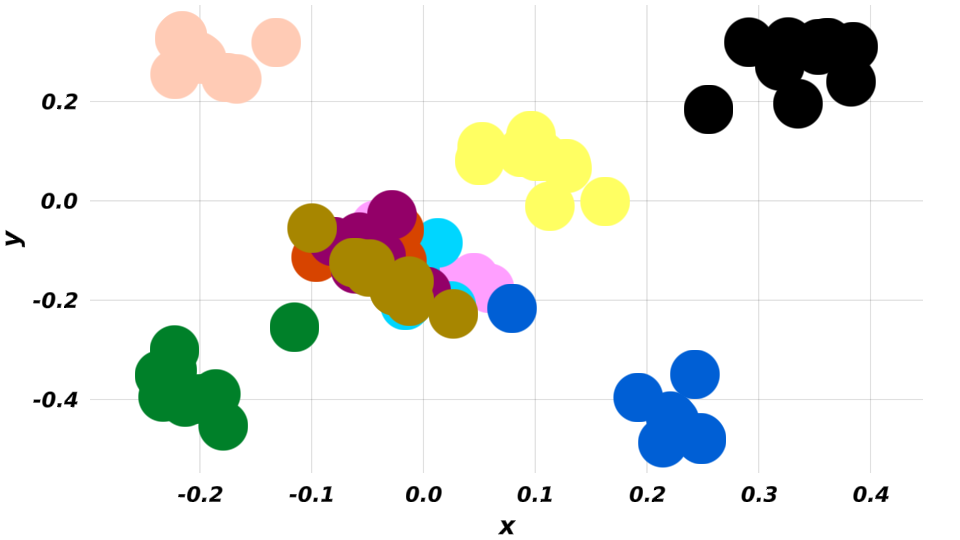

In [307]:
emb = enc(features)
scene = Scene(resolution = (500, 500))
scatter(emb[1, :], emb[2, :], color = colors)

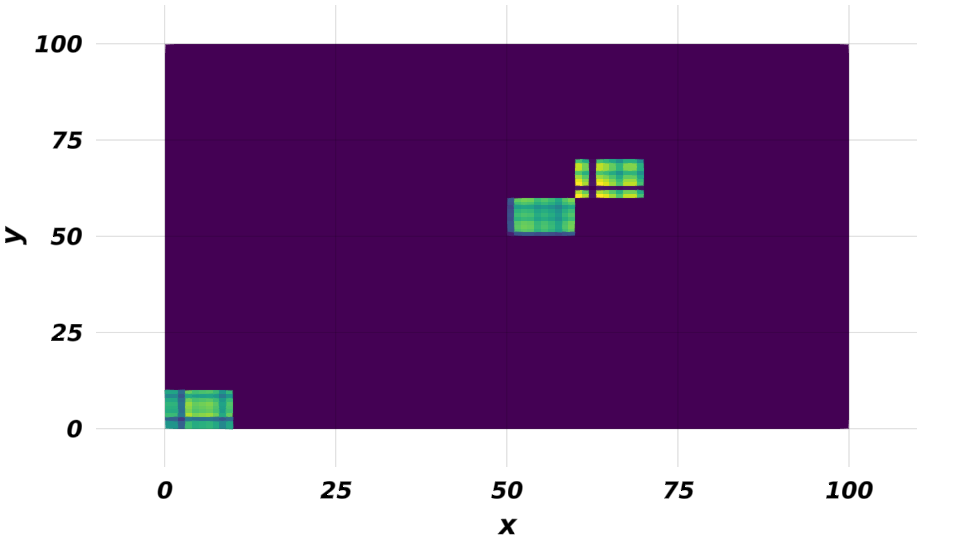

In [308]:
scene = Scene(resolution = (500, 500))
heatmap(ae(features).data)